In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"
import pandas as pd
pd.options.display.max_rows = 1000
import gc
import numpy as np
from tqdm import tqdm
from glob import glob
from sklearn.metrics import roc_auc_score
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
from torch.optim import SparseAdam, Adam
torch.backends.cudnn.benchmark = True
print(torch.__version__)
import cudf

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pickle
import random
import math
import time

def freemem(df):
    for col in df.columns:
        if df[col].dtype == 'int64':
            df[col] = df[col].astype('int32')
        elif df[col].dtype == 'float64':
            df[col] = df[col].astype('float32')
    gc.collect()
    return

device = 'cuda'
USE_GPU = torch.cuda.is_available()
print('Is GPU available?', USE_GPU)

1.13.1+cu117
Is GPU available? True


In [2]:
# !pip uninstall torch -y
# !pip install torch==1.12.1 torchvision torchaudio

# point to all your training parquet files
files = (
    list(glob('fold/train-full-split*')) +
    list(glob('fold/valid-trim-split*')) +
    list(glob('fold/test-full-split*')) +
    list(glob('fold/test-trim-split*'))
)
print(len(files))

119


In [3]:
train = pd.read_parquet(files)
train = cudf.from_pandas(train); gc.collect()
train = train.sort_values(['session', 'ts'], ascending=[True, True]).reset_index(drop=True)
freemem(train)

print(train.shape)
train.head()

(221231128, 4)


,session,aid,ts,type
0,0,1517085,1659304800,0
1,0,1563459,1659304904,0
2,0,1309446,1659367439,0
3,0,16246,1659367719,0
4,0,1781822,1659367871,0


In [4]:
train[f'ts_diff'] = train.groupby('session')['ts'].shift(1).fillna(0).astype('int32')
train[f'ts_diff'] = (train[f'ts'] - train[f'ts_diff'])
train[f'ts_diff'] = train[f'ts_diff'].clip(0, 24*60*60)
train.loc[train.ts_diff<2*60*60 , f'ts_diff'] = 0
train.loc[train.ts_diff>=2*60*60 , f'ts_diff'] = 1
gc.collect()
train[f'subses'] = train.groupby('session')['ts_diff'].cumsum()
train[f'subses'] = (train[f'session']*128 + train[f'subses']).factorize()[0]
print(train[f'ts_diff'].mean())
train.head(60)

0.19593754455747295


,session,aid,ts,type,ts_diff,subses
0,0,1517085,1659304800,0,1,0
1,0,1563459,1659304904,0,0,0
2,0,1309446,1659367439,0,1,1
3,0,16246,1659367719,0,0,1
4,0,1781822,1659367871,0,0,1
5,0,1152674,1659367885,0,0,1
6,0,1649869,1659369893,1,0,1
7,0,461689,1659369898,1,0,1
8,0,305831,1659370027,2,0,1
9,0,461689,1659370027,2,0,1


In [5]:
for lag in range(11):
    train[f'lag{lag}'] = train.groupby('subses')['aid'].shift(lag).fillna(-1).astype('int32')
    gc.collect()
    
del train['aid']
gc.collect()

train.head(60)

,session,ts,type,ts_diff,subses,lag0,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10
0,0,1659304800,0,1,0,1517085,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,0,1659304904,0,0,0,1563459,1517085,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,0,1659367439,0,1,1,1309446,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,0,1659367719,0,0,1,16246,1309446,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,0,1659367871,0,0,1,1781822,16246,1309446,-1,-1,-1,-1,-1,-1,-1,-1
5,0,1659367885,0,0,1,1152674,1781822,16246,1309446,-1,-1,-1,-1,-1,-1,-1
6,0,1659369893,1,0,1,1649869,1152674,1781822,16246,1309446,-1,-1,-1,-1,-1,-1
7,0,1659369898,1,0,1,461689,1649869,1152674,1781822,16246,1309446,-1,-1,-1,-1,-1
8,0,1659370027,2,0,1,305831,461689,1649869,1152674,1781822,16246,1309446,-1,-1,-1,-1
9,0,1659370027,2,0,1,461689,305831,461689,1649869,1152674,1781822,16246,1309446,-1,-1,-1


In [7]:
# (train[f'ts_diff']<1*60*60).mean()
freemem(train); gc.collect()

0

In [8]:
print(train.shape)
del train['ts_diff']; gc.collect()

train = train.loc[(train['type'] == 0) & (train['lag1'] >= 0)].reset_index(drop=True)
del train['type']
gc.collect()

print(train.shape)
train.head(60)

(221231128, 16)
(155850140, 14)


,session,ts,subses,lag0,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10
0,0,1659304904,0,1563459,1517085,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,0,1659367719,1,16246,1309446,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,0,1659367871,1,1781822,16246,1309446,-1,-1,-1,-1,-1,-1,-1,-1
3,0,1659367885,1,1152674,1781822,16246,1309446,-1,-1,-1,-1,-1,-1,-1
4,0,1659370064,1,362233,461689,305831,461689,1649869,1152674,1781822,16246,1309446,-1,-1
5,0,1659370067,1,1649869,362233,461689,305831,461689,1649869,1152674,1781822,16246,1309446,-1
6,0,1659371003,1,1649869,1649869,362233,461689,305831,461689,1649869,1152674,1781822,16246,1309446
7,0,1659371033,1,984597,1649869,1649869,362233,461689,305831,461689,1649869,1152674,1781822,16246
8,0,1659371042,1,1649869,984597,1649869,1649869,362233,461689,305831,461689,1649869,1152674,1781822
9,0,1659371044,1,803544,1649869,984597,1649869,1649869,362233,461689,305831,461689,1649869,1152674


In [9]:
train['hour'] = ((train['ts']-train['ts'].min()) // (8*60*60)).astype('int8') 
del train['ts'], train['subses']
gc.collect()
train.tail(20)

,session,lag0,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,hour
155850120,14571505,614588,1831249,-1,-1,-1,-1,-1,-1,-1,-1,-1,104
155850121,14571507,721034,191260,-1,-1,-1,-1,-1,-1,-1,-1,-1,104
155850122,14571511,1587854,1839213,-1,-1,-1,-1,-1,-1,-1,-1,-1,104
155850123,14571511,1839213,1587854,1839213,-1,-1,-1,-1,-1,-1,-1,-1,104
155850124,14571511,523147,1839213,1587854,1839213,-1,-1,-1,-1,-1,-1,-1,104
155850125,14571515,779748,779748,-1,-1,-1,-1,-1,-1,-1,-1,-1,104
155850126,14571515,781377,779748,779748,-1,-1,-1,-1,-1,-1,-1,-1,104
155850127,14571515,781377,781377,779748,779748,-1,-1,-1,-1,-1,-1,-1,104
155850128,14571517,685092,1052749,-1,-1,-1,-1,-1,-1,-1,-1,-1,104
155850129,14571517,712840,685092,1052749,-1,-1,-1,-1,-1,-1,-1,-1,104


In [10]:
train['hour'].max()

104

In [11]:
gc.collect()
train.to_pandas().to_parquet('train-proc-1.parquet'); gc.collect()

0

# Reload the DataFrame using RAM to save GPU memory for the model.

In [2]:
train = pd.read_parquet('train-proc-1.parquet'); gc.collect()
print(train.shape)
print(train.head())

(155850140, 13)
   session     lag0     lag1     lag2     lag3     lag4     lag5     lag6  \
0        0  1563459  1517085       -1       -1       -1       -1       -1   
1        0    16246  1309446       -1       -1       -1       -1       -1   
2        0  1781822    16246  1309446       -1       -1       -1       -1   
3        0  1152674  1781822    16246  1309446       -1       -1       -1   
4        0   362233   461689   305831   461689  1649869  1152674  1781822   

    lag7     lag8  lag9  lag10  hour  
0     -1       -1    -1     -1     0  
1     -1       -1    -1     -1     2  
2     -1       -1    -1     -1     2  
3     -1       -1    -1     -1     2  
4  16246  1309446    -1     -1     2  


In [3]:
for i in range(1, 11):
    print(i)
    train[f'lag{i}'] = train[f'lag{i}'].clip(0, None)
print(train.head())

1
2
3
4
5
6
7
8
9
10
   session     lag0     lag1     lag2     lag3     lag4     lag5     lag6  \
0        0  1563459  1517085        0        0        0        0        0   
1        0    16246  1309446        0        0        0        0        0   
2        0  1781822    16246  1309446        0        0        0        0   
3        0  1152674  1781822    16246  1309446        0        0        0   
4        0   362233   461689   305831   461689  1649869  1152674  1781822   

    lag7     lag8  lag9  lag10  hour  
0      0        0     0      0     0  
1      0        0     0      0     2  
2      0        0     0      0     2  
3      0        0     0      0     2  
4  16246  1309446     0      0     2  


In [5]:
train['lag0'].max()

1855602

In [6]:
train.columns

Index(['session', 'lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6',
       'lag7', 'lag8', 'lag9', 'lag10', 'hour'],
      dtype='object')

In [7]:
train['hour'] = train['hour'].astype('int32') + 1855602 + 1
train.head()

,session,lag0,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,hour
0,0,1563459,1517085,0,0,0,0,0,0,0,0,0,1855603
1,0,16246,1309446,0,0,0,0,0,0,0,0,0,1855605
2,0,1781822,16246,1309446,0,0,0,0,0,0,0,0,1855605
3,0,1152674,1781822,16246,1309446,0,0,0,0,0,0,0,1855605
4,0,362233,461689,305831,461689,1649869,1152674,1781822,16246,1309446,0,0,1855605


# Define the FM model

In [14]:
class MatrixFactorization(nn.Module):
    def __init__(self, n_aids=1855602+1, n_factors=32):
        super().__init__()
        self.aid_emb = nn.Embedding(1855602+128, n_factors, sparse=False)
        self.aid_emb.weight.data.normal_(mean=0.0, std=0.001)
        self.head = nn.Linear(11, 1)
        
    def forward(self, lags, targets):
        targets = torch.repeat_interleave(targets.view(-1,1), lags.shape[1], dim=1)
        tgt = self.aid_emb(targets)
        tgt = torch.nn.functional.normalize(tgt, p=2.0, dim=2, eps=1e-12)
        
        e1 = self.aid_emb(lags) 
        e1 = torch.nn.functional.normalize(e1, p=2.0, dim=2, eps=1e-12)
        e1 = e1 * tgt
        e1 = e1.sum(2)
        
        out = self.head(e1)
        return out.sigmoid()


model = MatrixFactorization(n_aids=1855602+1, n_factors=32)
model.train()

MatrixFactorization(
  (aid_emb): Embedding(1855730, 32)
  (head): Linear(in_features=11, out_features=1, bias=True)
)

# Try the model

In [15]:
lags = (1855603 * torch.rand(9, 11)).long()
targets = (1855603 * torch.rand(9)).long()

lags, targets#, hours

(tensor([[1483802, 1560624, 1116902, 1844227, 1469509, 1670194,  562653,  486352,
           563739, 1036391,  213661],
         [ 375778, 1207927, 1241742, 1225180,  445302,  681570,  584457, 1089499,
            37304,   62344, 1489221],
         [ 167102,   57664,  404427,   30056,  300046,   22421, 1756388,  155393,
           943200, 1384365,  588287],
         [ 801329, 1833403, 1766828, 1298855, 1687482,  198676, 1710288,  566690,
          1144775, 1195344, 1295309],
         [1485480, 1370313, 1141058,  377781,  453267,  522319,  993947,  814626,
           518737,  476102, 1376916],
         [ 334593,  967922,  380342,  775700,  667184,  536745,  737761, 1034205,
            98183,  337594, 1051202],
         [1671847,  938950, 1529360,  447881, 1853214,  655676, 1277604, 1062062,
            44365,  355475, 1827131],
         [1738993,  971909, 1234771,  886316,   40436,  358258, 1120957,  618116,
           649483,  964428,  108380],
         [1299657,  283043,  290810,   9

In [16]:
# targets = (1855603 * torch.rand(9)).long()
# print(targets.shape)
# torch.repeat_interleave(targets.view(-1,1), 11, dim=1)

In [17]:
model(lags, targets)

tensor([[0.4575],
        [0.4578],
        [0.4327],
        [0.4682],
        [0.4623],
        [0.4274],
        [0.4480],
        [0.4269],
        [0.4419]], grad_fn=<SigmoidBackward0>)

In [18]:
train.head()

,session,lag0,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,hour
0,0,1563459,1517085,0,0,0,0,0,0,0,0,0,1855603
1,0,16246,1309446,0,0,0,0,0,0,0,0,0,1855605
2,0,1781822,16246,1309446,0,0,0,0,0,0,0,0,1855605
3,0,1152674,1781822,16246,1309446,0,0,0,0,0,0,0,1855605
4,0,362233,461689,305831,461689,1649869,1152674,1781822,16246,1309446,0,0,1855605


In [43]:
def train_loop(model, iterator, optimizer, clip):
    
    criterion = nn.BCELoss().to(device)
    model.train()
    epoch_loss = 0.
    gc.collect()
    with tqdm(enumerate(iterator), total=len(iterator), miniters=100) as pbar:
        for i, (data, target) in pbar:    
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output_pos = model(data, target[:,0])
            
            #Shuffle target to build negative samples
            target = target[torch.randperm(target.shape[0])]
            output_neg = model(data, target[:,0])
            
            outputs = torch.cat([output_pos, output_neg])
            targets = torch.cat([torch.ones_like(output_pos), torch.zeros_like(output_neg)])
            loss = criterion(outputs, targets)
            
            del data, target

            loss.backward()
            #torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()

            epoch_loss += loss.item()
            cumloss = epoch_loss / (i+1)
            pbar.set_description(f"Loss {cumloss:.5f}")
    
    gc.collect()  
    return epoch_loss / len(iterator)


def valid_loop(model, iterator):
    ypred = []
    ytarget = []    
    epoch_loss = 0.

    model.eval()
    criterion = nn.BCELoss().to(device)
    with torch.no_grad():
        with tqdm(enumerate(iterator), total=len(iterator), miniters=50) as pbar:
            for i, (data, target) in pbar:    
                data, target = data.to(device), target.to(device)

                output_pos = model(data, target[:,0])

                #Shuffle target to build negative samples
                target = target[torch.randperm(target.shape[0])]
                output_neg = model(data, target[:,0])

                outputs = torch.cat([output_pos, output_neg])
                targets = torch.cat([torch.ones_like(output_pos), torch.zeros_like(output_neg)])
                loss = criterion(outputs, targets)
                
                ypred.append(outputs.cpu().numpy())
                ytarget.append(targets.cpu().numpy())
                del data, target

                epoch_loss += loss.item()
                cumloss = epoch_loss / (i+1)
                pbar.set_description(f"Loss {cumloss:.5f}")
                
    ypred = np.concatenate(ypred)
    ytarget = np.concatenate(ytarget)
    gc.collect()  
    
    auc = roc_auc_score(ytarget.flatten(), ypred.flatten())
    
    return epoch_loss / len(iterator), auc

gc.collect()

0

In [20]:
train.shape, device

((155850140, 13), 'cuda')

In [21]:
valid = train.loc[(train.session % 400)==11].copy().reset_index()
valid.shape

(384208, 14)

In [22]:
train = train.loc[(train.session % 400)!=11].reset_index()
gc.collect()
train.shape

(155465932, 14)

In [23]:
train.head()

,index,session,lag0,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,hour
0,0,0,1563459,1517085,0,0,0,0,0,0,0,0,0,1855603
1,1,0,16246,1309446,0,0,0,0,0,0,0,0,0,1855605
2,2,0,1781822,16246,1309446,0,0,0,0,0,0,0,0,1855605
3,3,0,1152674,1781822,16246,1309446,0,0,0,0,0,0,0,1855605
4,4,0,362233,461689,305831,461689,1649869,1152674,1781822,16246,1309446,0,0,1855605


In [24]:
train.dtypes

index      int64
session    int32
lag0       int32
lag1       int32
lag2       int32
lag3       int32
lag4       int32
lag5       int32
lag6       int32
lag7       int32
lag8       int32
lag9       int32
lag10      int32
hour       int32
dtype: object

In [25]:
TRAIN = train[['lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'hour']].values.copy()
VALID = valid[['lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'hour']].values.copy()
TRAIN_TARGET = train[['lag0']].values.copy()
VALID_TARGET = valid[['lag0']].values.copy()
del train, valid; gc.collect()
TRAIN.shape, VALID.shape

((155465932, 11), (384208, 11))

In [26]:
TRAIN[100]

array([1072782, 1072782, 1318324,  275288,       0,       0,       0,
             0,       0,       0, 1855654], dtype=int32)

In [27]:
model = MatrixFactorization(n_aids=1855602+1, n_factors=128).to(device)
#model.load_state_dict(torch.load('model-weights/fm_split_2_0.6040_v5.pt'))
#optimizer = optim.SparseAdam(model.parameters(), lr=0.000025)
optimizer = optim.Adam(model.parameters(), lr=0.000025)
gc.collect()
print(model)

MatrixFactorization(
  (aid_emb): Embedding(1855730, 128)
  (head): Linear(in_features=11, out_features=1, bias=True)
)


In [28]:
from torch.utils.data import TensorDataset

BS = 32*32*32

train_ds = TensorDataset(torch.as_tensor(TRAIN).long(), torch.as_tensor(TRAIN_TARGET).long())
train_dl = DataLoader(train_ds, BS, True, num_workers=4, drop_last=True, pin_memory=True)

valid_ds = TensorDataset(torch.as_tensor(VALID).long(), torch.as_tensor(VALID_TARGET).long())
valid_dl = DataLoader(valid_ds, BS, False, num_workers=4, drop_last=False, pin_memory=True)

print(len(valid_ds), len(valid_dl))

384208 12


In [47]:
!mkdir model-weights
for epoch in range(0, 15):
    train_loop(model, train_dl, optimizer, 1000.); gc.collect()
    valloss, auc = valid_loop(model, valid_dl); gc.collect()
    torch.save(model.state_dict(), f'model-weights/fm_split_{epoch}_{auc:.4f}_v10.pt');gc.collect()
    print(epoch, valloss, auc)

mkdir: cannot create directory ‘model-weights’: File exists


Loss 0.54965: 100%|██████████| 12/12 [00:01<00:00,  6.32it/s]


1 0.5496468643347422 0.8578703727299994


Loss 0.44632: 100%|██████████| 12/12 [00:01<00:00,  6.45it/s]


3 0.44631606340408325 0.9254181471300872


Loss 0.41265: 100%|██████████| 12/12 [00:01<00:00,  6.43it/s]


4 0.4126482233405113 0.93941904717138


Loss 0.38496: 100%|██████████| 12/12 [00:01<00:00,  6.23it/s]


5 0.3849613517522812 0.9492199955747681


Loss 0.36099: 100%|██████████| 12/12 [00:02<00:00,  5.29it/s]


6 0.36099473138650257 0.9561750077284741


Loss 0.33923: 100%|██████████| 12/12 [00:02<00:00,  5.62it/s]


7 0.3392256299654643 0.961422008678412


Loss 0.32002: 100%|██████████| 12/12 [00:02<00:00,  5.39it/s]


8 0.3200218652685483 0.965091086119508


Loss 0.30360: 100%|██████████| 12/12 [00:01<00:00,  6.19it/s]


9 0.30359644442796707 0.9674216405498735


# Reduce LR

In [48]:
# optimizer = optim.SparseAdam(model.parameters(), lr=0.000005)

# for epoch in range(15, 20):
#     train_loop(model, train_dl, optimizer, 1000.); gc.collect()
#     valloss = valid_loop(model, valid_dl); gc.collect()
#     torch.save(model.state_dict(), f'model-weights/fm_split_{epoch}_{valloss:.4f}_v10.pt');gc.collect()
#     print(epoch, valloss)

In [49]:
print(epoch, valloss)

9 0.30359644442796707


# Load last iteration and extract embeddings

In [51]:
# model = MatrixFactorization(n_aids=1855602+1, n_factors=128).to(device)
# model.load_state_dict(torch.load('model-weights/fm_split_9_0.9674_v10.pt'))
with torch.no_grad():
    embeddings = model.aid_emb.weight
    embeddings = torch.nn.functional.normalize(embeddings, p=2.0, dim=1, eps=1e-12)
    embeddings = embeddings.detach().cpu().numpy()
    
np.save('oof/embbedings_fm10.npy', embeddings)
embeddings.shape

(1855730, 128)

In [52]:
embeddings = np.load('oof/embbedings_fm10.npy')
embeddings.shape

(1855730, 128)

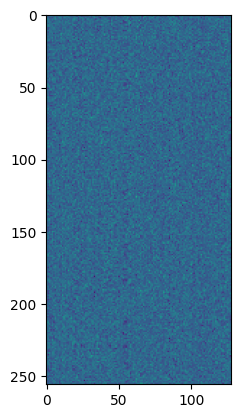

In [54]:
import matplotlib.pyplot as plt
plt.imshow(embeddings[:256])

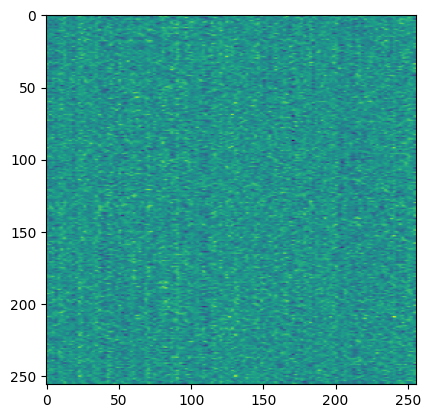

In [57]:
import cv2
plt.imshow( cv2.resize(embeddings[:1000000], (256,256)) )

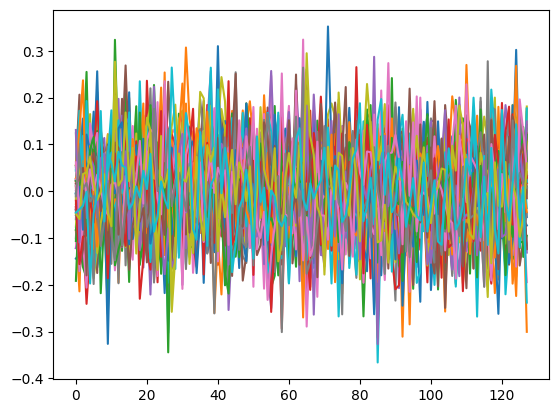

In [61]:
for i in range(50,100):
    plt.plot( embeddings[i] )

In [62]:
t = torch.tensor([[1.,2.,3.],[4.,5.,6.]])
torch.nn.functional.normalize(t, p=2.0, dim = 1)

tensor([[0.2673, 0.5345, 0.8018],
        [0.4558, 0.5698, 0.6838]])

In [63]:
def normalize(v):
    if len(v.shape)>1:
        return v / np.sqrt(np.sum(v**2, 1 , keepdims=True))
    else:
        return v / np.sqrt(np.sum(v**2))

t = np.array([[1.,2.,3.],[4.,5.,6.]])
normalize(t)

array([[0.26726124, 0.53452248, 0.80178373],
       [0.45584231, 0.56980288, 0.68376346]])

In [65]:
%%time
import cuml
from cuml.manifold import TSNE
tsne    = TSNE(n_components=2, perplexity=50, learning_rate=200, n_neighbors=5*50)
tsne_aid0 = tsne.fit_transform(embeddings)
tsne_aid0.shape, np.min(tsne_aid0), np.max(tsne_aid0)

/usr/local/lib/python3.8/dist-packages/cuml/internals/api_decorators.py:794: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


[W] [19:29:02.857293] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...
CPU times: user 5min 18s, sys: 3.09 s, total: 5min 21s
Wall time: 5min 22s


((1855730, 2), -6885.157, 4737.8564)

In [68]:
tsne_aid0 = np.clip(tsne_aid0, -250, 250)

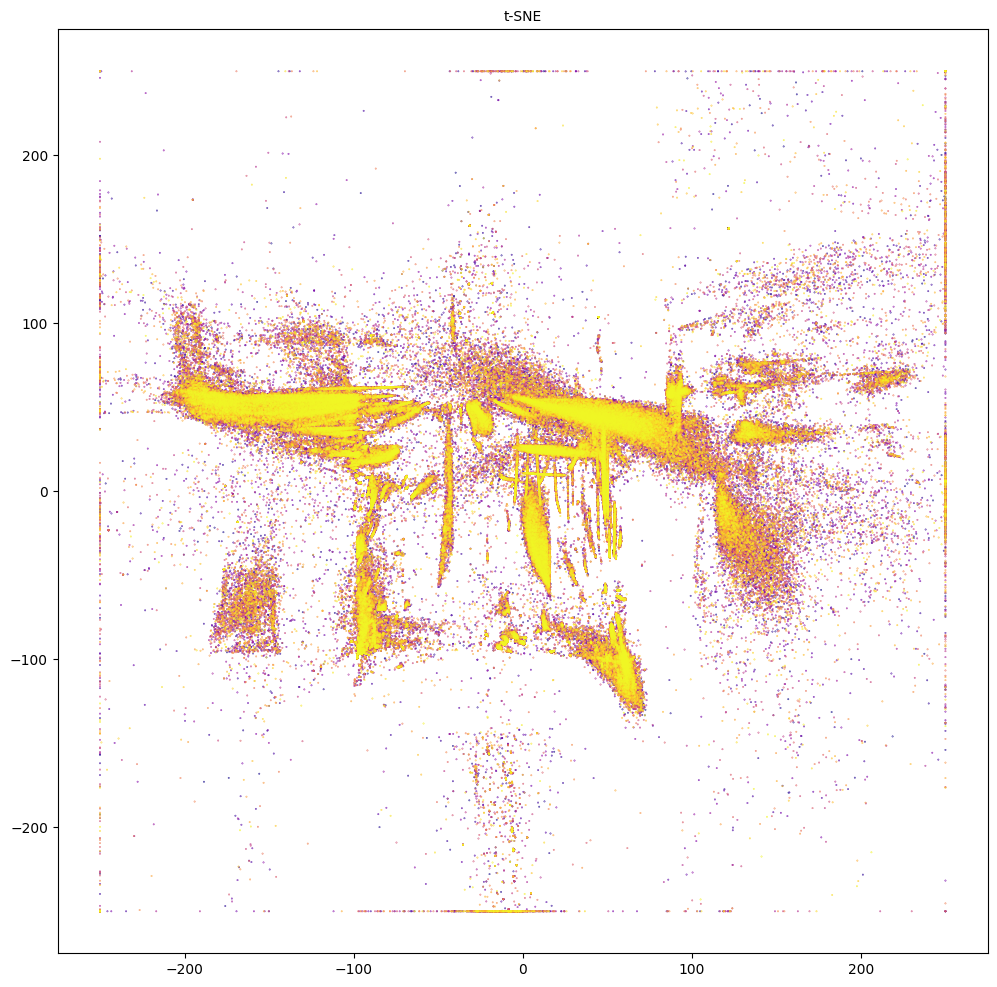

In [73]:
x = np.arange(tsne_aid0.shape[0])//7277
fig, ax = plt.subplots(figsize=(12, 12))
ax.scatter(tsne_aid0[:,0], tsne_aid0[:,1], s=0.1, c=x, cmap=plt.cm.plasma)
ax.set_title('t-SNE', fontsize=10)
plt.show();

In [74]:
%%time
# km = cuml.KMeans(n_clusters=128, max_iter=4000, n_init=8, oversampling_factor=4.0, max_samples_per_batch=65536)
# km.fit(tsne_aid0)
# np.unique(km.labels_, return_counts=True)

# fig, ax = plt.subplots(figsize=(12, 12))
# ax.scatter(tsne_aid0[:,0], tsne_aid0[:,1], s=0.1, c=km.labels_, cmap=plt.cm.plasma)
# ax.set_title('t-SNE', fontsize=10)
# plt.show();

CPU times: user 11 µs, sys: 0 ns, total: 11 µs
Wall time: 28.1 µs


In [70]:
# km = cuml.cluster.HDBSCAN(min_cluster_size=256, min_samples=2, cluster_selection_epsilon=0.0, max_cluster_size=0, metric='euclidean', alpha=1.0, p=2, verbose=True)
# km.fit(tsne_ses)
# np.unique(km.labels_, return_counts=True)

# fig, ax = plt.subplots(figsize=(12, 12))
# ax.scatter(tsne_ses[:,0], tsne_ses[:,1], s=0.1, c=km.labels_, cmap=plt.cm.plasma)
# ax.set_title('t-SNE', fontsize=10)
# plt.show();

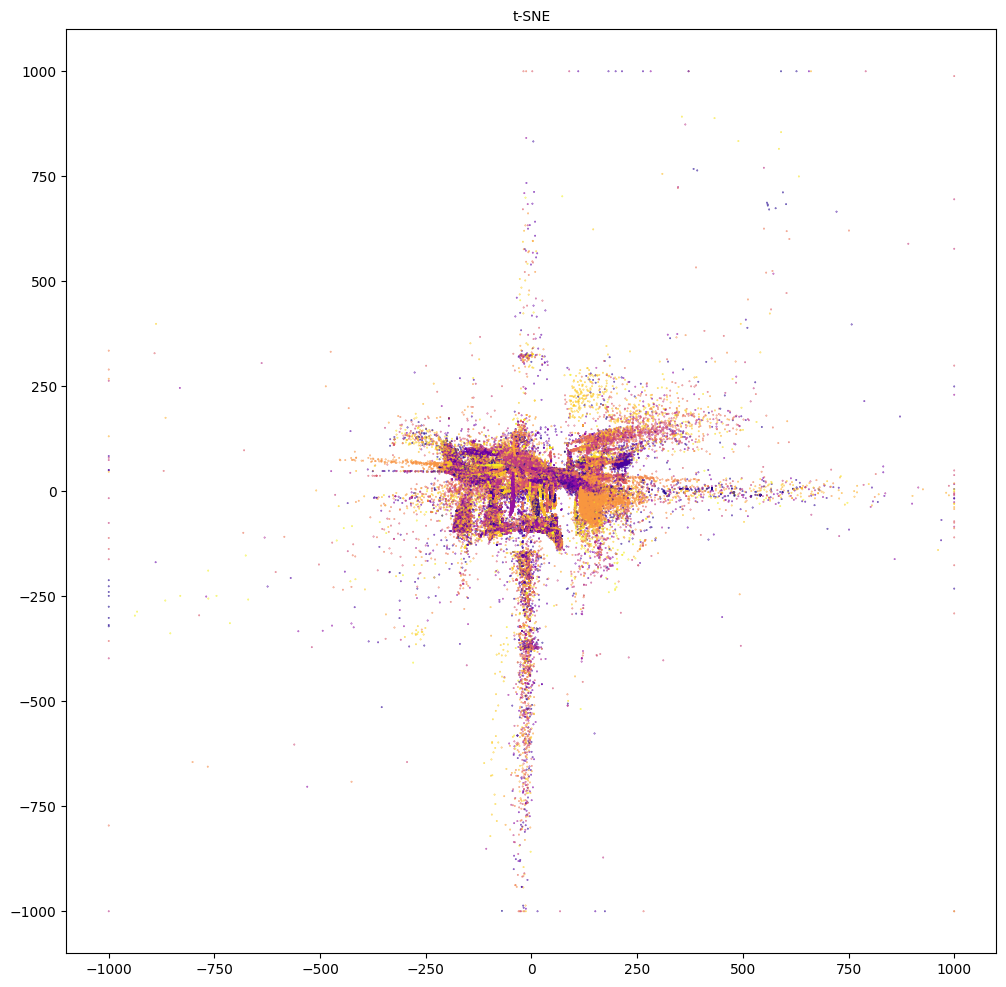

CPU times: user 1min 9s, sys: 3.13 s, total: 1min 12s
Wall time: 1min 10s


In [71]:
%%time
km1 = cuml.KMeans(n_clusters=128, max_iter=4000, n_init=8, oversampling_factor=4.0, max_samples_per_batch=65536)
km1.fit(normalize(embeddings))
#np.unique(km1.labels_, return_counts=True)

fig, ax = plt.subplots(figsize=(12, 12))
ax.scatter(tsne_aid0[:,0], tsne_aid0[:,1], s=0.1, c=km1.labels_, cmap=plt.cm.plasma)
ax.set_title('t-SNE', fontsize=10)
plt.show();

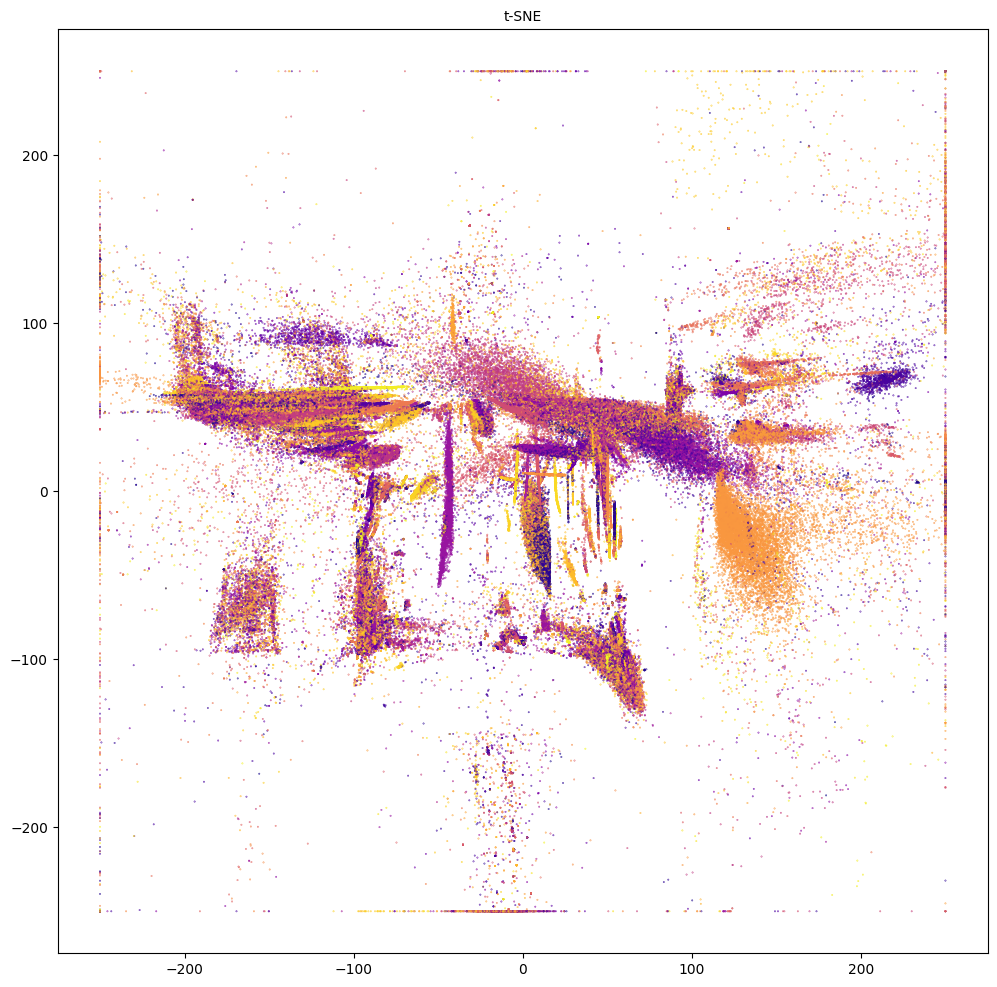

CPU times: user 1min 8s, sys: 2.43 s, total: 1min 10s
Wall time: 1min 9s


In [72]:
%%time
km1 = cuml.KMeans(n_clusters=128, max_iter=4000, n_init=8, oversampling_factor=4.0, max_samples_per_batch=65536)
km1.fit(normalize(embeddings))
#np.unique(km1.labels_, return_counts=True)

fig, ax = plt.subplots(figsize=(12, 12))
ax.scatter(tsne_aid0[:,0], tsne_aid0[:,1], s=0.1, c=km1.labels_, cmap=plt.cm.plasma)
ax.set_title('t-SNE', fontsize=10)
plt.show();

In [75]:
np.unique(km1.labels_, return_counts=True)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127], dtype=int32),
 array([  943, 24108, 10483,  7584,  5429,  5939, 28756, 16236, 13568,
        39682, 12787, 23044, 24945,  8385, 16277, 18120,  7769,  8483,
        10880,  8817, 18052, 13902, 11451, 21178, 34870, 21116,  9982,
        16656, 16158, 14794, 11430, 12451, 15336,  6

In [76]:
!mkdir embeddings
def torch_similarity(emb, emb_global, topk=50, batch_size=256):
    if type(emb_global) == np.ndarray:
        emb_global = torch.as_tensor(emb_global)
        emb_global = torch.nn.functional.normalize(emb_global, p=2.0, dim=1, eps=1e-12)
        embT = torch.transpose(emb_global, 0, 1).to('cuda')
    else:
        emb_global = torch.nn.functional.normalize(emb_global, p=2.0, dim=1, eps=1e-12)
        embT = torch.transpose(emb_global, 0, 1).to('cuda')

    if type(emb) == np.ndarray:
        emb = torch.as_tensor(emb)

    NN = []
    NNdist = []
    for batch in tqdm(range(0, emb.shape[0], batch_size)):
        emb_batch = torch.nn.functional.normalize(emb[batch:batch+batch_size].to('cuda'), p=2.0, dim=1, eps=1e-12)
        res = emb_batch @ embT
        dist, ind = torch.topk(res, topk, largest=True, sorted=True)
        NN.append(ind.cpu().numpy())
        NNdist.append(dist.cpu().numpy())
    NN = np.vstack(NN).astype('int32')
    NNdist = np.vstack(NNdist).astype('float32')
    
    del embT, batch, dist, ind, res
    gc.collect()
    return NN, NNdist

valind, valdist = torch_similarity(embeddings, embeddings, 100, 256)
gc.collect()
# np.save('embeddings/valind.npy', valind)
# np.save('embeddings/valdist.npy', valdist)

mkdir: cannot create directory ‘embeddings’: File exists


100%|██████████| 7249/7249 [04:03<00:00, 29.75it/s]


0

In [77]:
cluster0 = {i:km1.labels_[i]  for i in np.arange(len(embeddings))}
cluster0[0]

61

In [78]:
cand0 = {i:list(valind[i]) for i in np.arange(len(embeddings))}
cand0[0]

[0,
 1855656,
 1855659,
 1855650,
 1855662,
 1855661,
 1855658,
 1855668,
 1855632,
 1855635,
 1855626,
 1855665,
 1855647,
 1855667,
 1855671,
 1855629,
 1855649,
 1855664,
 1855634,
 1855631,
 1855638,
 1855617,
 1855646,
 1855640,
 1855652,
 1855641,
 1855620,
 1855623,
 1855655,
 1855605,
 1855619,
 1855637,
 1855643,
 1855653,
 1855625,
 1855644,
 1855622,
 1855642,
 1855608,
 1855628,
 1855611,
 1855677,
 1855660,
 1855663,
 1855616,
 1855614,
 1855657,
 1855639,
 1855604,
 1855651,
 1855648,
 1855645,
 1855670,
 1855679,
 1855666,
 1855682,
 1855621,
 1855680,
 1855686,
 1855683,
 1855636,
 1855669,
 1855618,
 1855674,
 1855627,
 1855607,
 1855624,
 1855633,
 1855613,
 1855610,
 1855630,
 1855673,
 1855603,
 1855676,
 1855654,
 1855703,
 1855685,
 1855707,
 1855704,
 1855609,
 1855672,
 1855692,
 1855706,
 1855612,
 1855697,
 1855615,
 1855606,
 1855695,
 1855698,
 1855701,
 1855684,
 1855681,
 1855678,
 1855689,
 1855700,
 1855675,
 1855705,
 906203,
 1855691,
 1855688]

In [79]:
cand0[110000]

[110000,
 797012,
 943588,
 1421002,
 86993,
 983562,
 1029541,
 205859,
 1789180,
 166204,
 791925,
 492889,
 471276,
 1701860,
 343699,
 83773,
 746,
 580293,
 1536838,
 517889,
 1431044,
 1590677,
 894190,
 1316593,
 1050553,
 1300511,
 781342,
 1099941,
 72626,
 1582397,
 521051,
 117847,
 157235,
 593460,
 729049,
 1142552,
 1326994,
 907805,
 1820555,
 1545346,
 626673,
 620446,
 631679,
 966875,
 506978,
 348821,
 621725,
 1353453,
 1436290,
 16611,
 1595258,
 1133215,
 90328,
 338631,
 1086484,
 712035,
 95091,
 1540578,
 1430837,
 471579,
 399734,
 359243,
 1571826,
 1667527,
 382381,
 576619,
 1519985,
 371191,
 589583,
 1098382,
 1118524,
 1213514,
 1066053,
 806184,
 720735,
 1816357,
 1210513,
 489005,
 1121726,
 1200397,
 165526,
 514803,
 63970,
 995408,
 762225,
 1235772,
 673924,
 589555,
 474641,
 1406921,
 1834054,
 87601,
 1540300,
 970156,
 315879,
 156235,
 613636,
 16582,
 1271731,
 1619110]

In [96]:
with open(f'oof/cluster_fm10.pkl', 'wb') as f:
    pickle.dump(cluster0, f)  
    
with open(f'oof/top50_fm10.pkl', 'wb') as f:
    pickle.dump(cand0, f)  

In [80]:
#emb = (aid0_emb[:1855603]+aid1_emb[:1855603]+aid2_emb[:1855603])/3
cand0[1111]

[1111,
 467175,
 1772360,
 964216,
 1689639,
 929079,
 1464632,
 634837,
 1494358,
 952409,
 751150,
 1659148,
 1728250,
 1093837,
 890061,
 264511,
 1416107,
 442797,
 1290798,
 1286604,
 444145,
 1398848,
 387922,
 153156,
 445374,
 407910,
 986106,
 1622779,
 1102510,
 944896,
 252069,
 28182,
 1569812,
 1637649,
 1777653,
 422368,
 371345,
 156475,
 1342315,
 1822316,
 1803578,
 491962,
 1365730,
 686335,
 1035278,
 712123,
 1119344,
 1435513,
 302604,
 1852008,
 529566,
 1479009,
 516596,
 1078600,
 1497421,
 624259,
 6151,
 1708319,
 298625,
 116300,
 662652,
 746140,
 1802237,
 829537,
 736798,
 1751276,
 1112541,
 42440,
 321320,
 814711,
 323006,
 608581,
 131236,
 438425,
 111473,
 1300260,
 1792373,
 594501,
 1094682,
 1553688,
 969217,
 383670,
 1503978,
 60014,
 205715,
 993778,
 1038385,
 1773703,
 906933,
 786640,
 1093763,
 1578691,
 1159062,
 226253,
 1596209,
 1556145,
 297994,
 1660470,
 866353,
 465638]

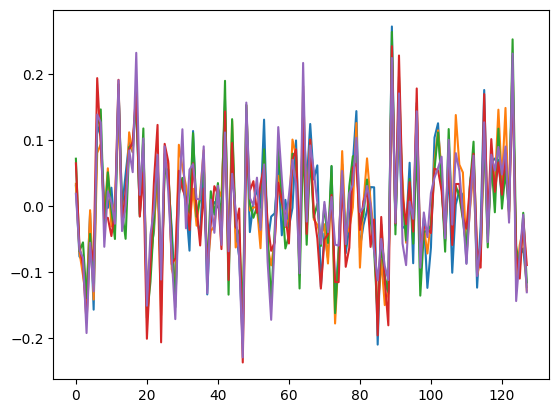

In [82]:
i = 111112
plt.plot( embeddings[cand0[i][0]] )
plt.plot( embeddings[cand0[i][1]] )
plt.plot( embeddings[cand0[i][2]] )
plt.plot( embeddings[cand0[i][3]] )
plt.plot( embeddings[cand0[i][-1]] )

In [84]:
label = pd.concat([
    pd.read_parquet('fold/labels-test.parquet'),
    pd.read_parquet('fold/labels.parquet')
])
label = label.loc[label['type']=='clicks'].copy().reset_index(drop=True)
label

,session,type,ground_truth
0,12899780,clicks,[1142000]
1,12899800,clicks,[609871]
2,12899820,clicks,[986164]
3,12899830,clicks,[1383942]
4,12899840,clicks,[1333534]
...,...,...,...
506417,12899774,clicks,[1399483]
506418,12899775,clicks,[1760714]
506419,12899776,clicks,[1737908]
506420,12899777,clicks,[384045]


In [85]:
files = (
    #list(glob('fold/train-full-split*')) +
    #list(glob('fold/valid-trim-split*'))
    #list(glob('fold/test-full-split*')) 
    list(glob('fold/test-trim-split*'))
)
print(len(files))

1


In [86]:
train = pd.read_parquet(files)
train = cudf.from_pandas(train); gc.collect()
train = train.sort_values(['session', 'ts'], ascending=[True, False]).reset_index(drop=True)

#train['ids'] = np.arange(train.shape[0])
train['n'] = train.groupby('session')['ts'].cumcount()
train['day'] = train['ts'] - train['ts'].min()
train['day'] = ((train['day']-4*60*60) // (24*60*60)).astype('int8') 
train['day'] = train['day'].clip(0, 100)
train['hour'] = (train['ts'] // (60*60)).astype('int32') 
freemem(train)

print(train.shape)
train.head()

(452070, 7)


,session,aid,ts,type,n,day,hour
0,12899780,736515,1661724136,0,0,0,461590
1,12899780,973453,1661724109,0,1,0,461590
2,12899780,582732,1661724058,0,2,0,461590
3,12899780,1142000,1661724000,0,3,0,461590
4,12899800,609871,1661724004,0,0,0,461590


In [88]:
train = train.loc[train['n'] == 0].copy().reset_index(drop=True)
train.head()

,session,aid,ts,type,n,day,hour
0,12899780,736515,1661724136,0,0,0,461590
1,12899800,609871,1661724004,0,0,0,461590
2,12899820,986164,1661724007,0,0,0,461590
3,12899830,1838106,1661724189,0,0,0,461590
4,12899840,409354,1661724012,0,0,0,461590


In [89]:
train['cand'] = train['aid'].map(cand0)
train

,session,aid,ts,type,n,day,hour,cand
0,12899780,736515,1661724136,0,0,0,461590,"[736515, 797055, 1712906, 1735169, 1097576, 16..."
1,12899800,609871,1661724004,0,0,0,461590,"[609871, 343254, 36748, 573713, 1837658, 46706..."
2,12899820,986164,1661724007,0,0,0,461590,"[986164, 785712, 615771, 1734305, 508883, 5840..."
3,12899830,1838106,1661724189,0,0,0,461590,"[1838106, 1411790, 394598, 189348, 1474524, 94..."
4,12899840,409354,1661724012,0,0,0,461590,"[409354, 1242619, 23307, 1602440, 861777, 1201..."
...,...,...,...,...,...,...,...,...
82375,14571400,52741,1662328625,1,0,6,461757,"[52741, 1572665, 78254, 1650839, 613534, 35582..."
82376,14571410,1518542,1662328586,0,0,6,461757,"[1518542, 1345697, 1228948, 1014894, 1428175, ..."
82377,14571430,903014,1662328616,1,0,6,461757,"[903014, 1220561, 464721, 1250786, 1851316, 13..."
82378,14571450,723612,1662328621,0,0,6,461757,"[723612, 423558, 138431, 1689819, 905993, 3490..."


In [91]:
train = train.to_pandas()

In [92]:
fmcands = {train.session.values[i]: list(train.cand.values[i]) for i in range(train.shape[0])}
len(fmcands)

82380

In [93]:
label['cand'] = label['session'].map(fmcands)
label

,session,type,ground_truth,cand
0,12899780,clicks,[1142000],"[736515, 797055, 1712906, 1735169, 1097576, 16..."
1,12899800,clicks,[609871],"[609871, 343254, 36748, 573713, 1837658, 46706..."
2,12899820,clicks,[986164],"[986164, 785712, 615771, 1734305, 508883, 5840..."
3,12899830,clicks,[1383942],"[1838106, 1411790, 394598, 189348, 1474524, 94..."
4,12899840,clicks,[1333534],"[409354, 1242619, 23307, 1602440, 861777, 1201..."
...,...,...,...,...
506417,12899774,clicks,[1399483],NaN
506418,12899775,clicks,[1760714],NaN
506419,12899776,clicks,[1737908],NaN
506420,12899777,clicks,[384045],NaN


In [94]:
label = label.loc[ label.cand.notnull() ].reset_index(drop=True)

In [100]:
label['hit'] = label.apply(lambda x: len(set(x.ground_truth).intersection(set(x.cand[1:21]))), axis=1)
label['hit'].mean()

0.17914542364651614

In [101]:
label['hit'] = label.apply(lambda x: len(set(x.ground_truth).intersection(set(x.cand[1:51]))), axis=1)
label['hit'].mean()

0.25864287448409806

In [102]:
label['hit'] = label.apply(lambda x: len(set(x.ground_truth).intersection(set(x.cand[1:]))), axis=1)
label['hit'].mean()

0.325455207574654